## Stance detection

Here is a simple baseline for stance detection using RoBERTa model from [Simple Transformers](https://simpletransformers.ai/) library.

In [100]:
%pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
#import libs
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import seaborn as sn
import matplotlib.pyplot as plt

In [102]:
#logging 
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

### Training

In [103]:
#read train dataset
train = pd.read_csv('data/train.csv', sep=',')

In [104]:
train.head(5)

,id,Tweet,Claim,Stance,Premise
0,3054935,@realDonaldTrump It's too dangerous to hold th...,school closures,FAVOR,1
1,453444,If masks are so important why is the public no...,face masks,AGAINST,1
2,211600,But if schools close who is gonna occupy those...,school closures,FAVOR,1
3,3049718,@GavinNewsom be the Governor I thought you wer...,stay at home orders,FAVOR,1
4,5039679580998,@BBCNews 1. You are reporting 78% uptake on ma...,face masks,FAVOR,1


In [105]:
#rename columns to match SimpleTransformers format
column_names = {'Tweet': 'text', 'Stance':'labels'}
train = train.rename(columns = column_names)

#change labels to match SimpleTransformers format
train.loc[train["labels"] == "AGAINST", "labels"] = 0
train.loc[train["labels"] == "FAVOR", "labels"] = 1
train.loc[train["labels"] == "NONE", "labels"] = 2

train

,id,text,Claim,labels,Premise
0,3054935,@realDonaldTrump It's too dangerous to hold th...,school closures,1,1
1,453444,If masks are so important why is the public no...,face masks,0,1
2,211600,But if schools close who is gonna occupy those...,school closures,1,1
3,3049718,@GavinNewsom be the Governor I thought you wer...,stay at home orders,1,1
4,5039679580998,@BBCNews 1. You are reporting 78% uptake on ma...,face masks,1,1
...,...,...,...,...,...
2751,2747057,@JohnCornyn Schools won't be safe until the vi...,school closures,1,1
2752,2120406711,@MorrisseyHelena @hughosmond @allisonpearson S...,face masks,2,1
2753,3006200,My family is living in fear because my brother...,school closures,1,1
2754,2400838291,@Leo_girl001 The D-Day is finally here. ... Y...,stay at home orders,2,0


Let's train our model!

In [106]:
%%time
model = ClassificationModel(
    "roberta", "roberta-base", num_labels=3, use_cuda=True, args={"overwrite_output_dir": True}
)
model.train_model(train)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

  0%|          | 0/2756 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/345 [00:00<?, ?it/s]

CPU times: user 44.8 s, sys: 7.46 s, total: 52.3 s
Wall time: 1min 6s


(345, 0.9275238202965778)

### Validation

In [107]:
#read validation dataset
val = pd.read_csv('data/validation.csv', sep=',')

#rename columns and values to match the format
val = val.rename(columns=column_names)
val.loc[val["labels"] == "AGAINST", "labels"] = 0
val.loc[val["labels"] == "FAVOR", "labels"] = 1
val.loc[val["labels"] == "NONE", "labels"] = 2

In [108]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(val)
result

  0%|          | 0/600 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/75 [00:00<?, ?it/s]

{'mcc': 0.4289560035198193, 'eval_loss': 0.8451575215657552}

In [109]:
#Make predictions on validation tweets
val = val.dropna()
tweets_val = list(val['text'])
stance_predictions = model.predict(tweets_val)[0]
val['predictions'] = stance_predictions

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [110]:
val

,id,text,Claim,labels,Premise,predictions
0,7212131785749,Ordered a mask that had a cute chain attached ...,face masks,1,0,1
1,2367433035,Who is ready for some #baseball? #BaseballisB...,stay at home orders,2,0,2
2,496011,"@Mystere07623203 @va_shiva @Liberty13046 130,0...",face masks,1,1,2
3,1490686,When they ask me what I did with my life I wil...,face masks,1,0,1
4,1209366,Taylor not putting her album in physical store...,stay at home orders,1,0,2
...,...,...,...,...,...,...
595,2949472,@BrianKempGA is one of the few #Governors that...,face masks,0,1,1
596,208269,I tested positive for Covid. Got it from a fri...,face masks,1,1,1
597,2316008,"If you are under retirement age, you have a *m...",stay at home orders,0,1,1
598,659269,@TheLalasventure @doqholliday @realDonaldTrump...,face masks,1,0,1


In [111]:
import numpy as np

In [112]:
y_true = list(val['labels'].to_numpy())
y_pred = list(val['predictions'].to_numpy())

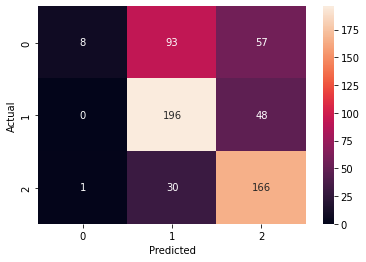

In [113]:
#Let's look at model's predictions distribution
confusion_matrix = pd.crosstab(val['labels'], val['predictions'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [114]:
#Mapping back integer labels to words
val.loc[val["predictions"] == 0, "predictions"] = "AGAINST"
val.loc[val["predictions"] == 1, "predictions"] = "FAVOR"
val.loc[val["predictions"] == 2, "predictions"] = "NONE"
#Final submission is need to be in the following format
val = val.drop(columns=['labels', 'Premise']).rename(columns={'predictions':
                                                      'Stance'})
val

,id,text,Claim,Stance
0,7212131785749,Ordered a mask that had a cute chain attached ...,face masks,FAVOR
1,2367433035,Who is ready for some #baseball? #BaseballisB...,stay at home orders,NONE
2,496011,"@Mystere07623203 @va_shiva @Liberty13046 130,0...",face masks,NONE
3,1490686,When they ask me what I did with my life I wil...,face masks,FAVOR
4,1209366,Taylor not putting her album in physical store...,stay at home orders,NONE
...,...,...,...,...
595,2949472,@BrianKempGA is one of the few #Governors that...,face masks,FAVOR
596,208269,I tested positive for Covid. Got it from a fri...,face masks,FAVOR
597,2316008,"If you are under retirement age, you have a *m...",stay at home orders,FAVOR
598,659269,@TheLalasventure @doqholliday @realDonaldTrump...,face masks,FAVOR


In [116]:
from sklearn.metrics import classification_report

In [117]:
y_true = list(y_true)
y_pred = [i for i in y_pred]

In [118]:
print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       0.89      0.05      0.10       158
           1       0.61      0.80      0.70       244
           2       0.61      0.84      0.71       197

    accuracy                           0.62       599
   macro avg       0.71      0.57      0.50       599
weighted avg       0.69      0.62      0.54       599

